In [1]:
# importing required libraries

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.preprocessing import sequence
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
print(tf.__version__)
%matplotlib inline
np.random.seed(1)

2.2.0-rc3


Part 1. Data preparation<br>
1.1 Load HDF5 data using Pandas API. The data imported by pandas is a multiindex
dataframe where index level 0 is the unique patient encounter identifier and
index level 1 is the time of each measurement in units of hours since first
measurement.

In [0]:
# loading data

x_train = pd.read_hdf('./X_train.hdf')
y_train = pd.read_hdf('./y_train.hdf')
x_test = pd.read_hdf('./X_test.hdf')
y_test = pd.read_hdf('./y_test.hdf')

1.2 Find how many patient encounters are there in the training set; how many
timestamps are measured in total; and how many types of measurements are
documented.

In [4]:
print("Number of patient encounters",len(x_train.index.levels[0]))

Number of patient encounters 5000


In [5]:
print("Measured Timestamps",len(x_train.index.levels[1]))

Measured Timestamps 76693


In [6]:
print("Types of Measurements Documented",x_train.shape[1])

Types of Measurements Documented 265


1.3 For each patient encounter, find how many times measurements have taken,
and plot a histogram showing the number of times each patient encounter is
measured.

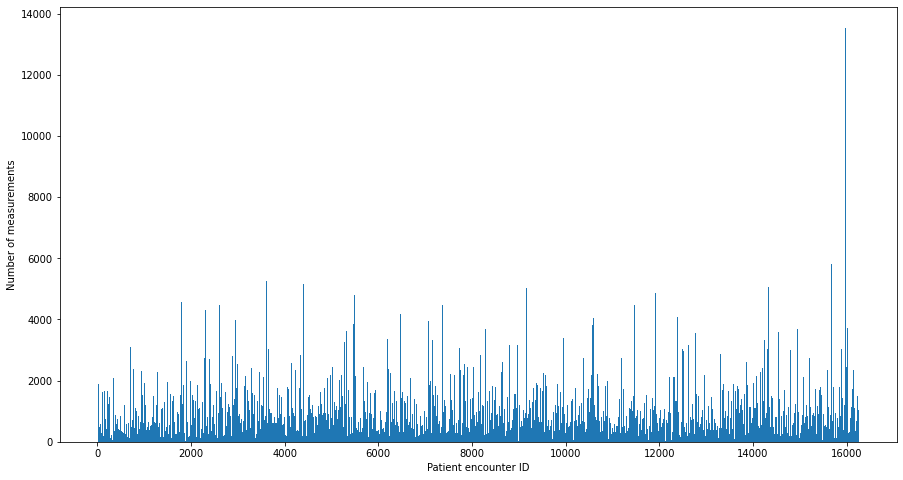

In [7]:
hist = Counter(x_train.index.to_frame(index=False)['encounterID'])
fig = plt.figure(figsize=(15,8))
plt.hist(list(hist.keys()), bins=980, weights = list(hist.values()))
#plt.bar(list(hist.keys()), list(hist.values()), width = 20)
plt.ylabel('Number of measurements')
plt.xlabel('Patient encounter ID')
plt.show()

1.4 Perform data normalization for all numerical measurements.

In [0]:
#min max normalization

x_train = ((x_train-x_train.min())/(x_train.max()-x_train.min())).astype(np.float64)
x_test = ((x_test-x_test.min())/(x_test.max()-x_test.min())).astype(np.float64)

1.5 For each patient encounter, fill in missing data point using forward filling, i.e.,
use the last measurement for all missing measurement till the next time stamp
when another measurement is made. If there was not a previous measurement,
fill in missing point(s) by zeros.

In [0]:
x_train = x_train.fillna(method='ffill')
x_train = x_train.fillna(0)

x_test = x_test.fillna(method='ffill')
x_test = x_test.fillna(0)

1.6 Set the maximum length of sequence for each patient encounter to the 90
percentile of length. Truncate or zero-pad to the same maximum length for all
patient encounter sequences.

In [0]:
#Creating list of data by each encounter id, final shape 5000 x number of measurements of each encounter id x 265
#and labels to 5000 x number of measurements of each encounter id

train_data = [x_train.loc[i].values for i in x_train.index.levels[0]]
#for i in x_train.index.levels[0]:
#    train_data.append(x_train.loc[i].values)
    
test_data = [x_test.loc[i].values for i in x_test.index.levels[0]]
#for i in x_test.index.levels[0]:
#    test_data.append(x_test.loc[i].values)
    
train_labels = [y_train.loc[i].values[:,0] for i in x_train.index.levels[0]]
#for i in x_train.index.levels[0]:
#    train_labels.append(y_train.loc[i].values[-1][0])
    
test_labels = [y_test.loc[i].values[:,0] for i in x_test.index.levels[0]]
#for i in x_test.index.levels[0]:
#    test_labels.append(y_test.loc[i].values[-1][0])

#finding 90 % of number of measurements per encounter id

maxlen = sorted(hist.values())[:int(len(hist)*0.9)][-1]   # <---- maxlen value is 523

#padding data and making it to 5000 x 523 x 265 and labels to 5000 x 523

train_data = sequence.pad_sequences(train_data, maxlen=maxlen, padding='post', truncating='post', dtype='float')
test_data = sequence.pad_sequences(test_data, maxlen=maxlen, padding='post', truncating='post', dtype='float')
train_labels = sequence.pad_sequences(train_labels, maxlen=maxlen, padding='post', truncating='post', dtype='float')
test_labels = sequence.pad_sequences(test_labels, maxlen=maxlen, padding='post', truncating='post', dtype='float')

Part 2 RNN Model Selection<br>
2.1) A base-line LSTM model<br>
a) Build a single hidden layer LSTM model with 128 neurons that will take a
sequence of data as input, and make a binary prediction on weather a patient can
survive.

In [11]:
def build_model():
    
    model = keras.Sequential([
        LSTM(128, input_shape = (train_data.shape[1], train_data.shape[2]), return_sequences = True),
        Dense(1, activation='sigmoid')
    ])
    adam = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, decay=0.1)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 523, 128)          201728    
_________________________________________________________________
dense (Dense)                (None, 523, 1)            129       
Total params: 201,857
Trainable params: 201,857
Non-trainable params: 0
_________________________________________________________________


In [12]:
num_epochs = 10

all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

model = build_model()
history = model.fit(train_data, train_labels, epochs=num_epochs, batch_size = 32, validation_split=0.2)

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

Epoch 1/10
125/125 [==============================] - 7s 54ms/step - loss: 0.1076 - accuracy: 0.9704 - val_loss: 0.0840 - val_accuracy: 0.9729
Epoch 2/10
125/125 [==============================] - 5s 43ms/step - loss: 0.0810 - accuracy: 0.9727 - val_loss: 0.0764 - val_accuracy: 0.9728
Epoch 3/10
125/125 [==============================] - 5s 43ms/step - loss: 0.0742 - accuracy: 0.9750 - val_loss: 0.0771 - val_accuracy: 0.9713
Epoch 4/10
125/125 [==============================] - 5s 43ms/step - loss: 0.0731 - accuracy: 0.9750 - val_loss: 0.0734 - val_accuracy: 0.9759
Epoch 5/10
125/125 [==============================] - 5s 43ms/step - loss: 0.0723 - accuracy: 0.9756 - val_loss: 0.0727 - val_accuracy: 0.9761
Epoch 6/10
125/125 [==============================] - 5s 43ms/step - loss: 0.0711 - accuracy: 0.9758 - val_loss: 0.0730 - val_accuracy: 0.9752
Epoch 7/10
125/125 [==============================] - 5s 43ms/step - loss: 0.0706 - accuracy: 0.9759 - val_loss: 0.0713 - val_accuracy: 0.9765

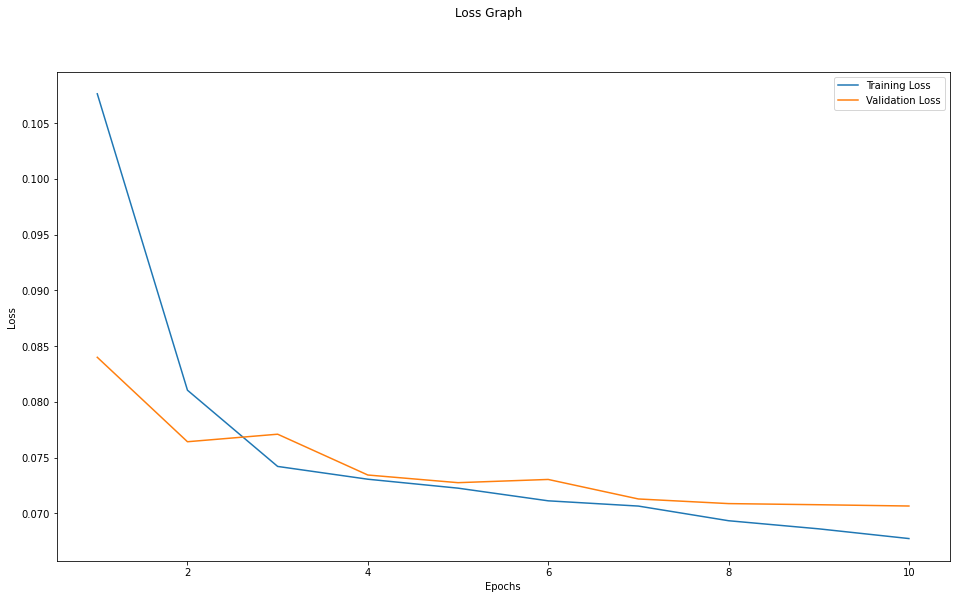

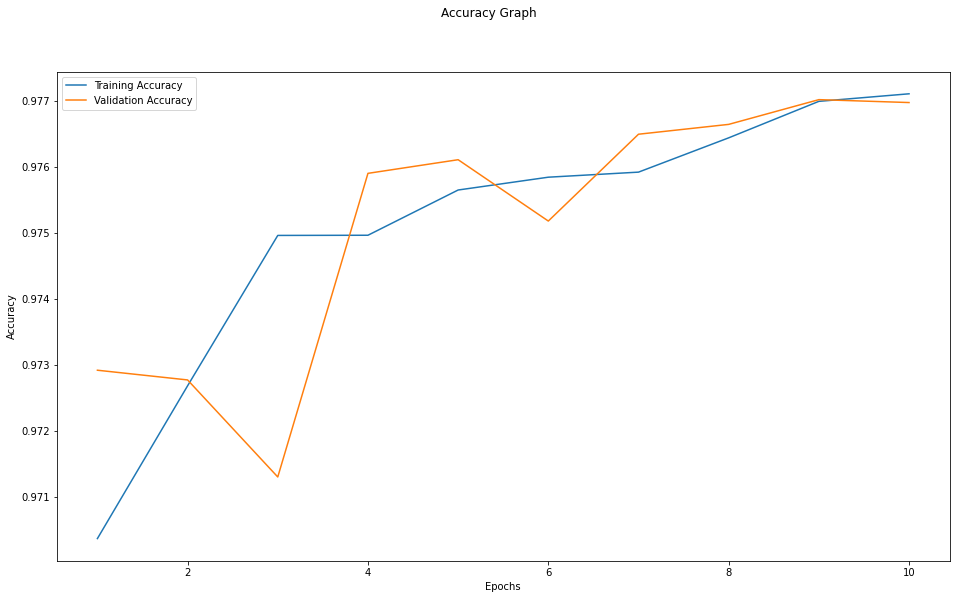

In [13]:
def plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories):
    plt.rcParams['figure.figsize'] = (16.0, 9.0)
    
    # Averaging Total fold's accuracy into 1
    average_accuracy_history = [np.mean([x[i] for x in all_accuracy_histories]) for i in range(num_epochs)]
    average_val_accuracy_history = [np.mean([x[i] for x in all_val_accuracy_histories]) for i in range(num_epochs)]
    average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
    average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
    
    #plotting training and validation loss into 1 graph
    plt.plot(range(1, len(average_loss_history) + 1), average_loss_history, label = 'Training Loss')
    plt.plot(range(1, len(average_val_loss_history) + 1), average_val_loss_history, label = 'Validation Loss')
    plt.suptitle('Loss Graph')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    #plotting training and validation accuracy into 1 graph
    plt.plot(range(1, len(average_accuracy_history) + 1), average_accuracy_history, label = 'Training Accuracy')
    plt.plot(range(1, len(average_val_accuracy_history) + 1), average_val_accuracy_history, label = 'Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.suptitle('Accuracy Graph')
    plt.legend()
    plt.show()
    
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

c. Evaluate your model using the testing set. Find the sensitivity and precision for
your model.

In [14]:
loss, acc = model.evaluate(test_data, test_labels)

85/85 [==============================] - 1s 17ms/step - loss: 0.0116 - accuracy: 0.9963


In [15]:
def precision(test_classes, y_test):
    scores=np.where(y_test.reshape(-1)==test_classes,1,0)
    mean_acc=np.mean(scores)
    print('Testing Accuracy = ',mean_acc*100,"%")
    precision = precision_score(y_test.reshape(-1), np.array(test_classes))
    print('Precision = ',precision)
    recall = recall_score(y_test.reshape(-1), np.array(test_classes))
    print('Sensitivity = ', recall)

test_classes = model.predict(test_data, verbose = 0)
test_classes_step = np.array([0 if i<0.5 else 1 for i in test_classes.reshape(-1)])
precision(test_classes_step, test_labels)

Testing Accuracy =  99.63223325538252 %
Precision =  0.9474893584962519
Sensitivity =  0.98702436854979


d. Plot the ROC curve of your model and compute the AUC for your model using
sklearn.metrics functions.

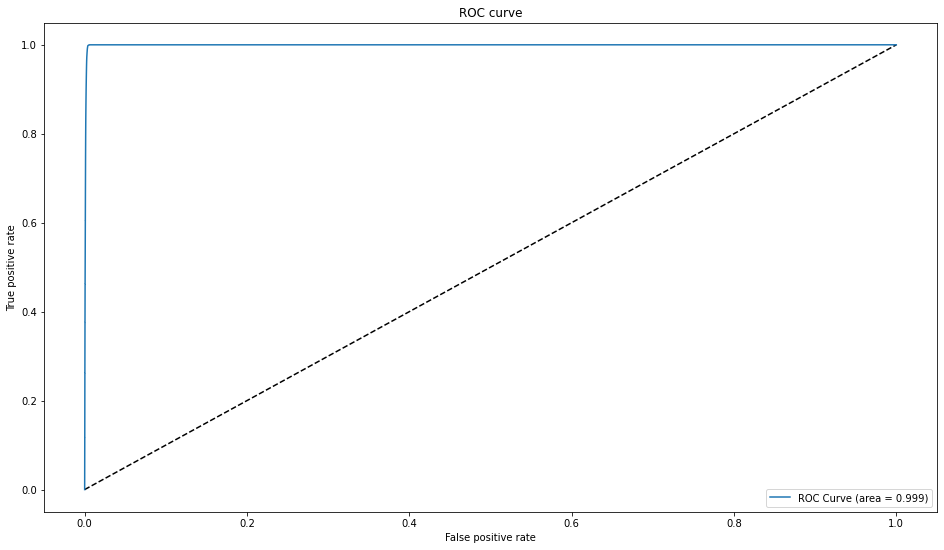

In [16]:
def roc(test_classes, y_test):
    fpr, tpr, _ = roc_curve(y_test.reshape(-1), test_classes)
    auc_score = auc(fpr,tpr)
    fig = plt.figure(figsize=(16,9))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label = 'ROC Curve (area = {:.3f})'.format(auc_score))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
#proba = model.predict_proba(x_test, verbose = 0).reshape(-1)
roc(test_classes.reshape(-1), test_labels)

Removing Padded data and checking accyracy analysis again. Part c and d.

Testing Accuracy =  93.70949897265687 %
Precision =  0.9474893584962519
Sensitivity =  0.98702436854979


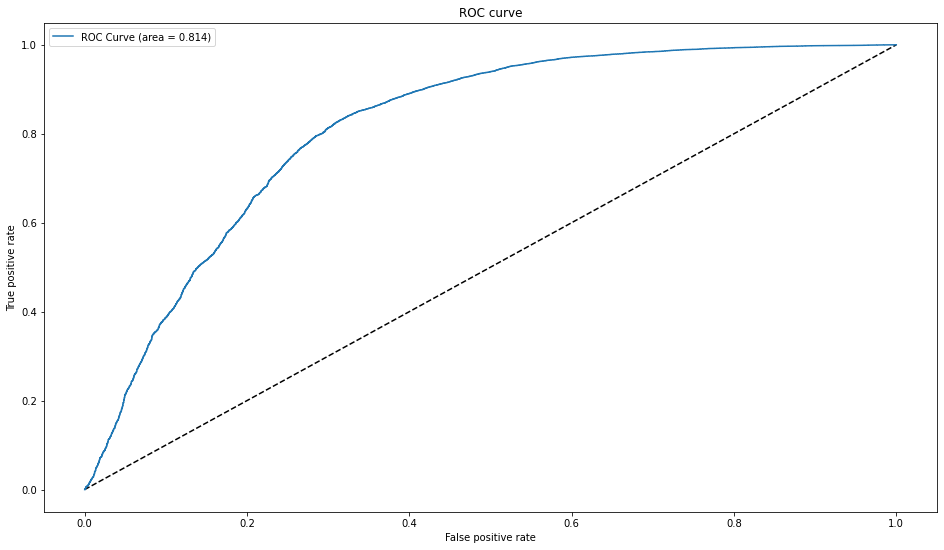

In [17]:
t_hist = Counter(x_test.index.to_frame(index=False)['encounterID'])
w_test_labels = []
j=0
for i in y_test.index.levels[0]:
  w_test_labels.append(test_classes[j][:t_hist[i]])
  j+=1

final_labels = []
for i in range(len(w_test_labels)):
  for j in w_test_labels[i]:
    final_labels.append(j)

final_labels = np.array(final_labels).ravel()
final_classes_step = np.array([0 if i<0.5 else 1 for i in final_labels.reshape(-1)])
precision(final_classes_step, y_test.values.ravel())
roc(final_labels.reshape(-1), y_test.values.ravel())

In [18]:
dict = Counter(final_classes_step)
print('Predicted set\nNumber of dead patient\'s',dict[0])
print('Number of Alive patient\'s',dict[1])

o_dict = Counter(y_test.values.ravel().reshape(-1))
print('\nOriginal set\nNumber of dead patient\'s',o_dict[0])
print('Number of Alive patient\'s',o_dict[1])

Predicted set
Number of dead patient's 2610
Number of Alive patient's 79641

Original set
Number of dead patient's 5800
Number of Alive patient's 76451


2.2) Change the architecture of the LSTM model, such as using different nnmber
of neurons, and adding more hidden layers, repeat part b-d in 2.1, and find the
best performing model.

In [29]:
def build_model():
    
    model = keras.Sequential([
        LSTM(32, input_shape = (train_data.shape[1], train_data.shape[2]), return_sequences = True),
        LSTM(64, return_sequences = True),
        LSTM(128, return_sequences = True),
        Dense(1, activation='sigmoid')
    ])
    adam = keras.optimizers.RMSprop(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model
model = build_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 523, 32)           38144     
_________________________________________________________________
lstm_18 (LSTM)               (None, 523, 64)           24832     
_________________________________________________________________
lstm_19 (LSTM)               (None, 523, 128)          98816     
_________________________________________________________________
dense_7 (Dense)              (None, 523, 1)            129       
Total params: 161,921
Trainable params: 161,921
Non-trainable params: 0
_________________________________________________________________


In [30]:
num_epochs = 10

all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

model = build_model()
history = model.fit(train_data, train_labels, epochs=num_epochs, batch_size = 32, validation_split=0.2)

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

Epoch 1/10
125/125 [==============================] - 11s 92ms/step - loss: 0.1696 - accuracy: 0.9603 - val_loss: 0.0916 - val_accuracy: 0.9729
Epoch 2/10
125/125 [==============================] - 10s 79ms/step - loss: 0.0918 - accuracy: 0.9729 - val_loss: 0.0836 - val_accuracy: 0.9731
Epoch 3/10
125/125 [==============================] - 10s 79ms/step - loss: 0.0790 - accuracy: 0.9726 - val_loss: 0.0735 - val_accuracy: 0.9729
Epoch 4/10
125/125 [==============================] - 10s 79ms/step - loss: 0.0781 - accuracy: 0.9748 - val_loss: 0.0813 - val_accuracy: 0.9756
Epoch 5/10
125/125 [==============================] - 10s 79ms/step - loss: 0.0777 - accuracy: 0.9748 - val_loss: 0.0868 - val_accuracy: 0.9734
Epoch 6/10
125/125 [==============================] - 10s 79ms/step - loss: 0.0743 - accuracy: 0.9745 - val_loss: 0.0750 - val_accuracy: 0.9743
Epoch 7/10
125/125 [==============================] - 10s 79ms/step - loss: 0.0754 - accuracy: 0.9759 - val_loss: 0.0682 - val_accuracy:

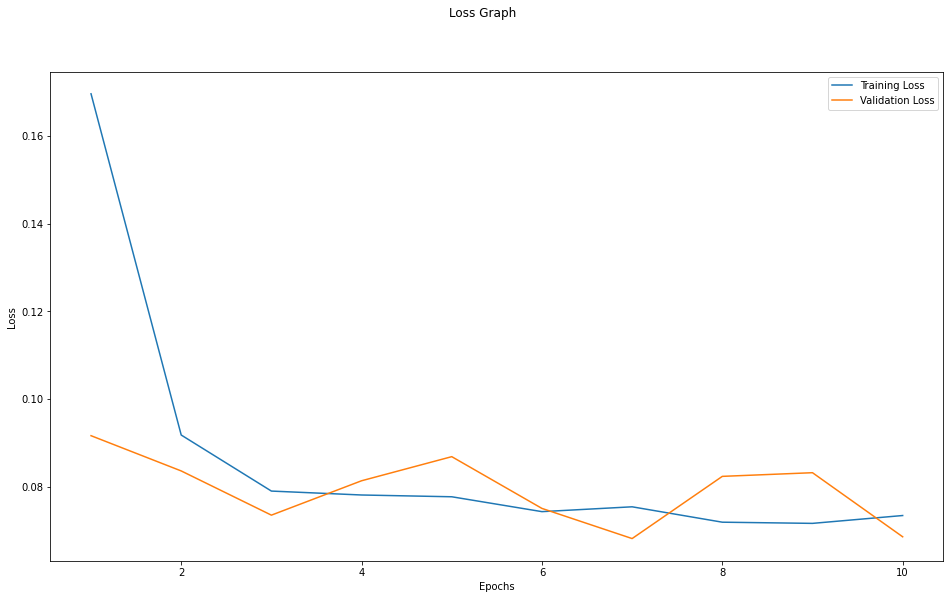

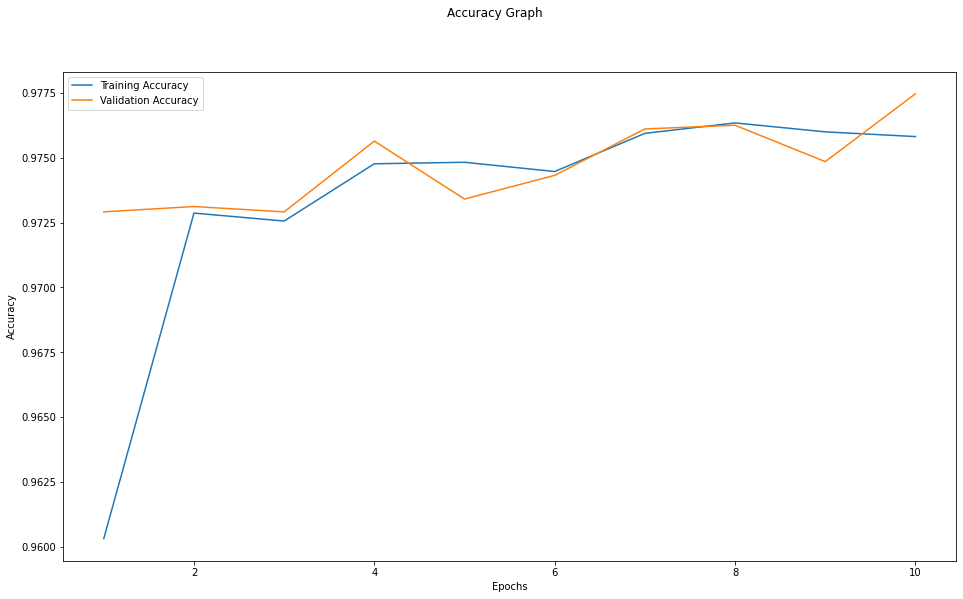

In [31]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

In [32]:
los, acc = model.evaluate(test_data, test_labels)

85/85 [==============================] - 3s 31ms/step - loss: 0.0114 - accuracy: 0.9962


Testing Accuracy =  99.62029185354724 %
Precision =  0.9529062583595531
Sensitivity =  0.9784829498633112


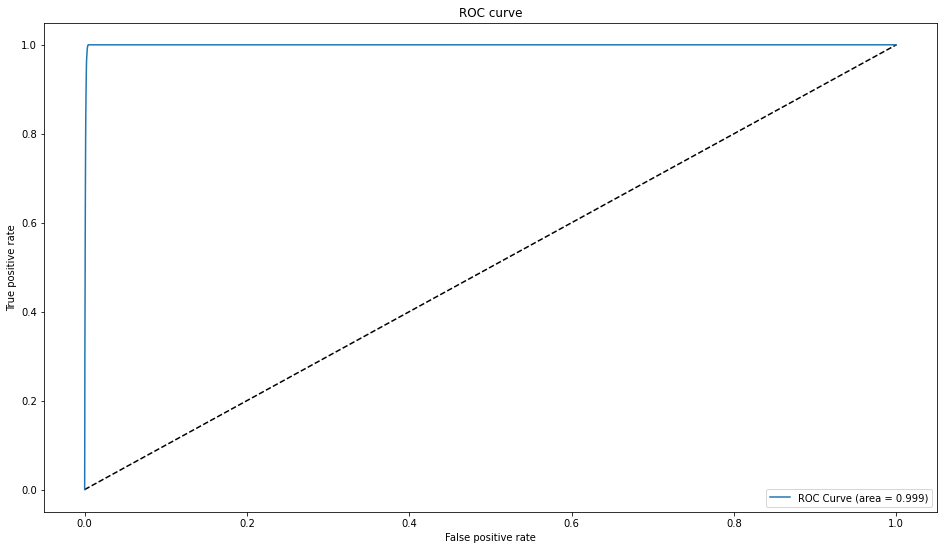

In [33]:
test_classes = model.predict(test_data, verbose = 0)
test_classes_step = np.array([0 if i<0.5 else 1 for i in test_classes.reshape(-1)])
precision(test_classes_step, test_labels)
roc(test_classes.reshape(-1), test_labels)

Testing Accuracy =  93.50524613682508 %
Precision =  0.9529062583595531
Sensitivity =  0.9784829498633112


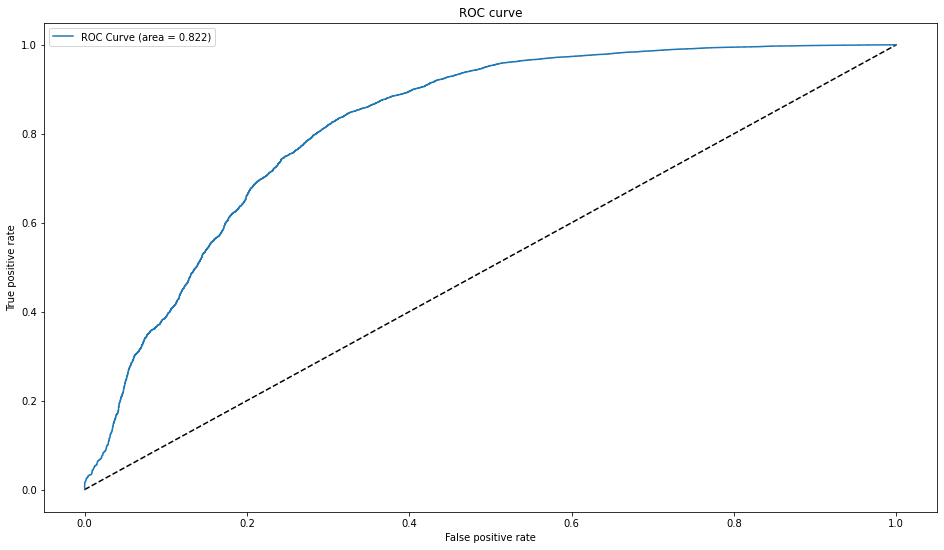

In [34]:
t_hist = Counter(x_test.index.to_frame(index=False)['encounterID'])
w_test_labels = []
j=0
for i in y_test.index.levels[0]:
  w_test_labels.append(test_classes[j][:t_hist[i]])
  j+=1

final_labels = []
for i in range(len(w_test_labels)):
  for j in w_test_labels[i]:
    final_labels.append(j)

final_labels = np.array(final_labels).ravel()
final_classes_step = np.array([0 if i<0.5 else 1 for i in final_labels.reshape(-1)])
precision(final_classes_step, y_test.values.ravel())
roc(final_labels.reshape(-1), y_test.values.ravel())

In [35]:
dict = Counter(final_classes_step)
print('Predicted set\nNumber of dead patient\'s',dict[0])
print('Number of Alive patient\'s',dict[1])

o_dict = Counter(y_test.values.ravel().reshape(-1))
print('\nOriginal set\nNumber of dead patient\'s',o_dict[0])
print('Number of Alive patient\'s',o_dict[1])

Predicted set
Number of dead patient's 3748
Number of Alive patient's 78503

Original set
Number of dead patient's 5800
Number of Alive patient's 76451


2.3) Change the LSTM models to GRU models, and repeat part 2.2, compare the
results.

In [47]:
def build_model():
    
    model = keras.Sequential([
        GRU(32, input_shape = (train_data.shape[1], train_data.shape[2]), return_sequences = True),
        GRU(64, return_sequences = True),
        GRU(128, return_sequences = True),
        Dense(1, activation='sigmoid')
    ])
    adam = keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model
model = build_model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 523, 32)           28704     
_________________________________________________________________
gru_7 (GRU)                  (None, 523, 64)           18816     
_________________________________________________________________
gru_8 (GRU)                  (None, 523, 128)          74496     
_________________________________________________________________
dense_11 (Dense)             (None, 523, 1)            129       
Total params: 122,145
Trainable params: 122,145
Non-trainable params: 0
_________________________________________________________________


In [48]:
num_epochs = 10

all_accuracy_histories = []
all_val_accuracy_histories = []
all_loss_histories = []
all_val_loss_histories = []

model = build_model()
history = model.fit(train_data, train_labels, epochs=num_epochs, batch_size = 32, validation_split=0.2)

accuracy_history = history.history['accuracy']
val_accuracy_history = history.history['val_accuracy']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

all_accuracy_histories.append(accuracy_history)
all_val_accuracy_histories.append(val_accuracy_history)
all_loss_histories.append(loss_history)
all_val_loss_histories.append(val_loss_history)

Epoch 1/10
125/125 [==============================] - 10s 82ms/step - loss: 0.1202 - accuracy: 0.9672 - val_loss: 0.0820 - val_accuracy: 0.9755
Epoch 2/10
125/125 [==============================] - 9s 73ms/step - loss: 0.0827 - accuracy: 0.9741 - val_loss: 0.0939 - val_accuracy: 0.9730
Epoch 3/10
125/125 [==============================] - 9s 73ms/step - loss: 0.0788 - accuracy: 0.9738 - val_loss: 0.0723 - val_accuracy: 0.9757
Epoch 4/10
125/125 [==============================] - 9s 73ms/step - loss: 0.0765 - accuracy: 0.9741 - val_loss: 0.0701 - val_accuracy: 0.9755
Epoch 5/10
125/125 [==============================] - 9s 74ms/step - loss: 0.0750 - accuracy: 0.9751 - val_loss: 0.0691 - val_accuracy: 0.9755
Epoch 6/10
125/125 [==============================] - 9s 73ms/step - loss: 0.0735 - accuracy: 0.9753 - val_loss: 0.0723 - val_accuracy: 0.9747
Epoch 7/10
125/125 [==============================] - 9s 73ms/step - loss: 0.0728 - accuracy: 0.9764 - val_loss: 0.0688 - val_accuracy: 0.975

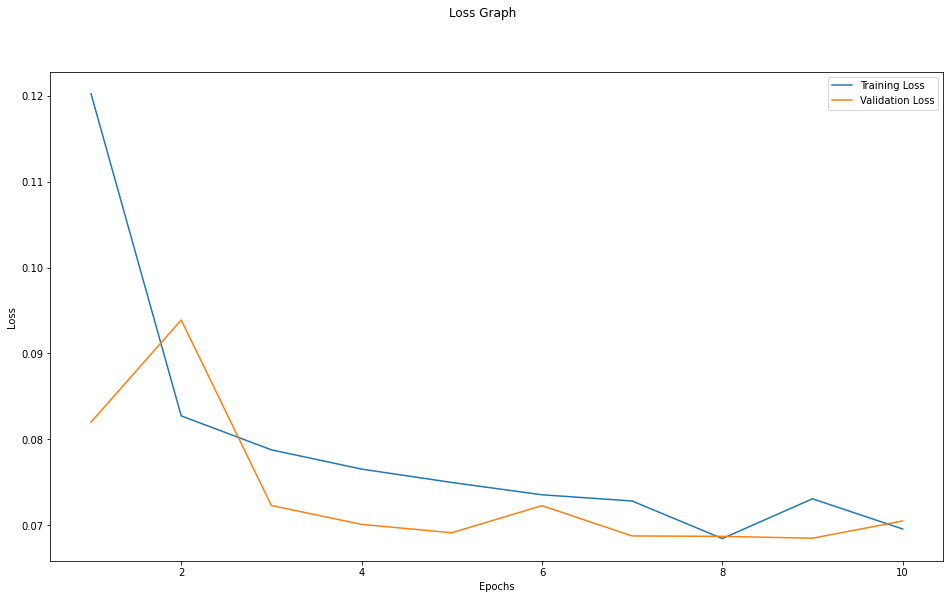

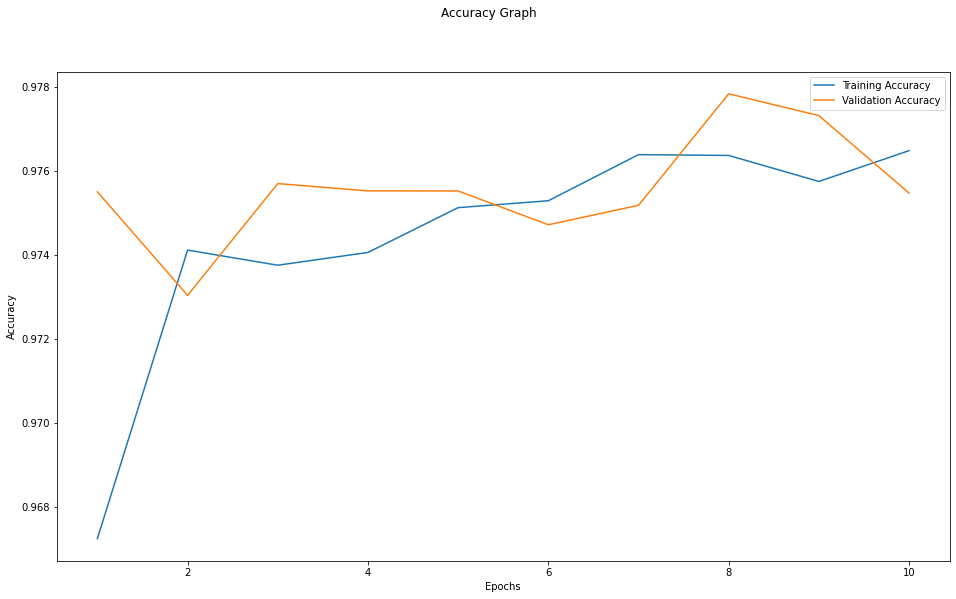

In [49]:
plot_accuracy(all_accuracy_histories, all_val_accuracy_histories, all_loss_histories, all_val_loss_histories)

In [50]:
los, acc = model.evaluate(test_data, test_labels)

85/85 [==============================] - 2s 29ms/step - loss: 0.0119 - accuracy: 0.9963


Testing Accuracy =  99.62988762287915 %
Precision =  0.9409973259383976
Sensitivity =  0.9942315993250579


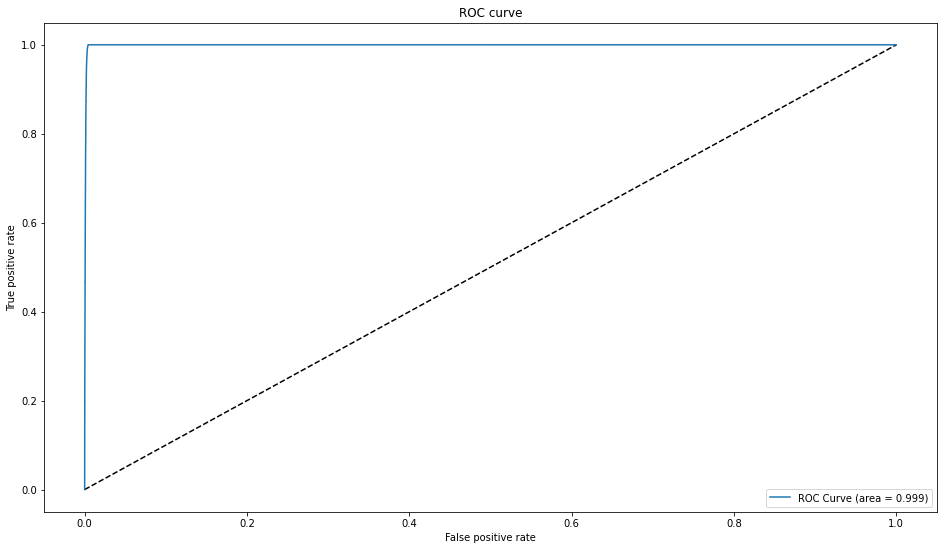

In [51]:
test_classes = model.predict(test_data, verbose = 0)
test_classes_step = np.array([0 if i<0.5 else 1 for i in test_classes.reshape(-1)])
precision(test_classes_step, test_labels)
roc(test_classes.reshape(-1), test_labels)

Testing Accuracy =  93.66937787990419 %
Precision =  0.9409973259383976
Sensitivity =  0.9942315993250579


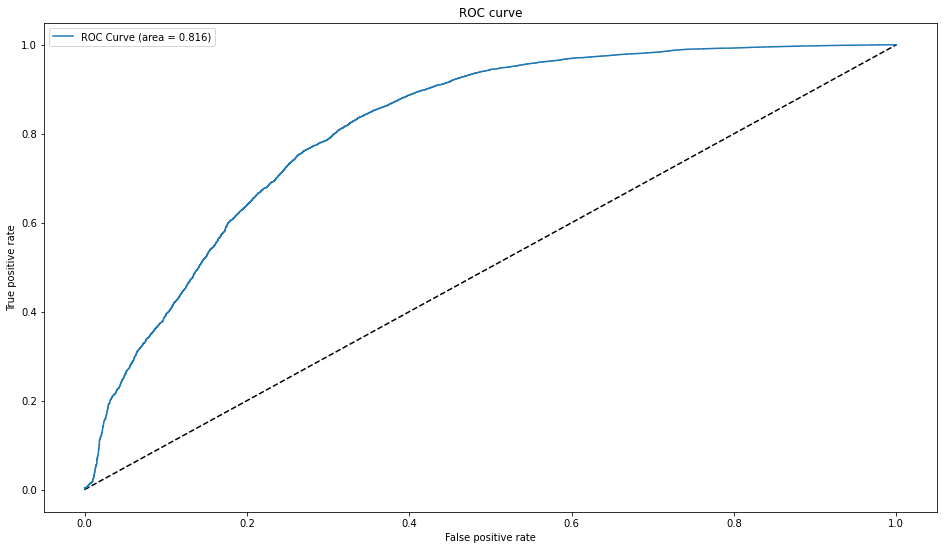

In [52]:
t_hist = Counter(x_test.index.to_frame(index=False)['encounterID'])
w_test_labels = []
j=0
for i in y_test.index.levels[0]:
  w_test_labels.append(test_classes[j][:t_hist[i]])
  j+=1

final_labels = []
for i in range(len(w_test_labels)):
  for j in w_test_labels[i]:
    final_labels.append(j)

final_labels = np.array(final_labels).ravel()
final_classes_step = np.array([0 if i<0.5 else 1 for i in final_labels.reshape(-1)])
precision(final_classes_step, y_test.values.ravel())
roc(final_labels.reshape(-1), y_test.values.ravel())

In [53]:
dict = Counter(final_classes_step)
print('Predicted set\nNumber of dead patient\'s',dict[0])
print('Number of Alive patient\'s',dict[1])

o_dict = Counter(y_test.values.ravel().reshape(-1))
print('\nOriginal set\nNumber of dead patient\'s',o_dict[0])
print('Number of Alive patient\'s',o_dict[1])

Predicted set
Number of dead patient's 1475
Number of Alive patient's 80776

Original set
Number of dead patient's 5800
Number of Alive patient's 76451
